Clasificación de imágenes


Este tutorial sigue un flujo de trabajo básico de aprendizaje automático:

1-Examinar y comprender los datos.

2-Crear una canalización de entrada

3-Construye el modelo

4-Entrenar al modelo

5-Probar el modelo

6-Mejorar el modelo y repetir el proceso

Importamos bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Descargar y explorar el conjunto de datos

El dataset tiene 3700 fotos de flores

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


A continuacion mostraremos algunas rosas y tulipanes

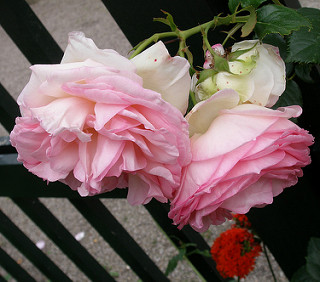

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))



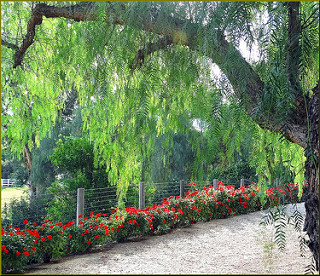

In [5]:
PIL.Image.open(str(roses[1]))


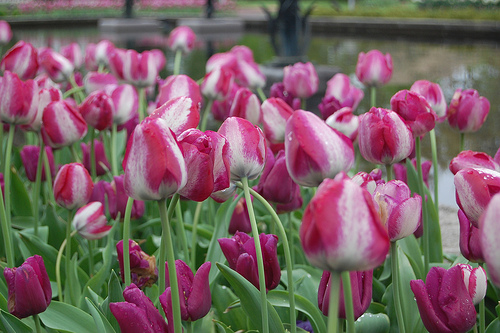

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


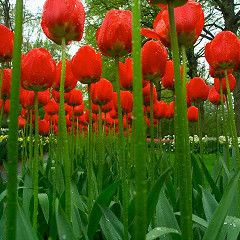

In [7]:
PIL.Image.open(str(tulips[1]))

Cargar datos usando una utilidad Keras

Crear dataset


<br>
las buenas practicas, 80% entrenamiento y 20 de validacion

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Visualizar los datos

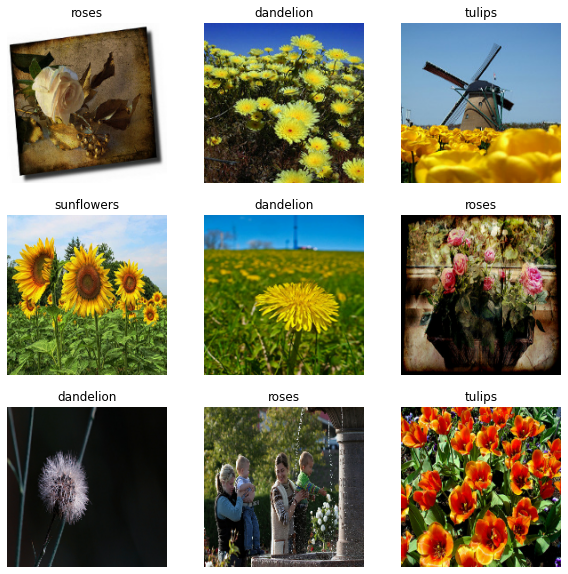

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.Rescaling(1./255)


In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9995425


El modelo secuencial consta de tres bloques de convolución ( tf.keras.layers.Conv2D ) con una capa de agrupación máxima ( tf.keras.layers.MaxPooling2D ) en cada uno de ellos. Hay una capa totalmente conectada ( tf.keras.layers.Dense ) con 128 unidades encima que se activa mediante una función de activación de ReLU ( 'relu' ). Este modelo no se ha ajustado para una alta precisión; el objetivo de este tutorial es mostrar un enfoque estándar.

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compilar el modelo
Para este tutorial, elija el optimizador tf.keras.optimizers.Adam y la función de pérdida tf.keras.losses.SparseCategoricalCrossentropy . Para ver la precisión del entrenamiento y la validación para cada época de entrenamiento, pase el argumento de metrics a Model.compile .

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Resumen del modelo

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 95s 1s/step - loss: 1.4191 - accuracy: 0.3890 - val_loss: 1.1196 - val_accuracy: 0.5422
Epoch 2/10
92/92 [==============================] - 95s 1s/step - loss: 1.0717 - accuracy: 0.5634 - val_loss: 1.0395 - val_accuracy: 0.5899
Epoch 3/10
92/92 [==============================] - 92s 999ms/step - loss: 0.8697 - accuracy: 0.6652 - val_loss: 0.9542 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 94s 1s/step - loss: 0.6518 - accuracy: 0.7558 - val_loss: 0.9796 - val_accuracy: 0.6185
Epoch 5/10
92/92 [==============================] - 92s 1000ms/step - loss: 0.4133 - accuracy: 0.8552 - val_loss: 1.2349 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 101s 1s/step - loss: 0.2610 - accuracy: 0.9183 - val_loss: 1.1624 - val_accuracy: 0.6213
Epoch 7/10
92/92 [==============================] - 97s 1s/step - loss: 0.1557 - accuracy: 0.9513 - val_loss: 1.4587 - val_accuracy: 0.6185
Epoch 8/10
9

Graficos de perdida y precisionen los conjuntos de entrenamiento y validacion.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Los gráficos muestran que la precisión del entrenamiento y la precisión de la validación están desviadas por amplios márgenes, y el modelo ha logrado solo alrededor del 60 % de precisión en el conjunto de validación.

Inspeccionemos qué salió mal e intentemos aumentar el rendimiento general del modelo.

Sobreajuste<br>
En los gráficos anteriores, la precisión del entrenamiento aumenta linealmente con el tiempo, mientras que la precisión de la validación se detiene alrededor del 60 % en el proceso de entrenamiento. Además, la diferencia en la precisión entre la precisión del entrenamiento y la validación es notable, un signo de sobreajuste .

Cuando hay una pequeña cantidad de ejemplos de entrenamiento, el modelo a veces aprende de los ruidos o detalles no deseados de los ejemplos de entrenamiento, hasta el punto de afectar negativamente el rendimiento del modelo en los nuevos ejemplos. Este fenómeno se conoce como sobreajuste. Significa que el modelo tendrá dificultades para generalizar en un nuevo conjunto de datos.

Hay múltiples formas de combatir el sobreajuste en el proceso de entrenamiento. En este tutorial, utilizará el aumento de datos y agregará Dropout a su modelo.

Aumento de datos<br>
El sobreajuste generalmente ocurre cuando hay una pequeña cantidad de ejemplos de entrenamiento. El aumento de datos adopta el enfoque de generar datos de entrenamiento adicionales a partir de sus ejemplos existentes al aumentarlos mediante transformaciones aleatorias que producen imágenes de aspecto creíble. Esto ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Abandonar<br>Otra técnica para reducir el sobreajuste es introducir la regularización de abandonos en la red.

Cuando aplica abandono a una capa, descarta aleatoriamente (estableciendo la activación en cero) una cantidad de unidades de salida de la capa durante el proceso de entrenamiento. Dropout toma un número fraccionario como su valor de entrada, en forma de 0.1, 0.2, 0.4, etc. Esto significa eliminar aleatoriamente el 10%, 20% o 40% de las unidades de salida de la capa aplicada.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compilar y entrenar el modelo.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Visualiza los resultados del entrenamiento

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predecir con nuevos datos<br>Finalmente, usemos nuestro modelo para clasificar una imagen que no se incluyó en los conjuntos de entrenamiento o validación.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)